In [1]:
%load_ext autoreload
%autoreload 2
import os, sys
import numpy as np
import pandas as pd

from sklearn import decomposition, metrics
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.neighbors import KNeighborsClassifier

import enrichr
import evaluations

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('talk')

In [3]:
# Download enrichr libs 
lib_names = [
    'ChEA_2016', 'ENCODE_TF_ChIP-seq_2015', 'ENCODE_Histone_Modifications_2015',
    'TRANSFAC_and_JASPAR_PWMs', 'Genome_Browser_PWMs',
    'KEGG_2016', 'KEA_2015',
    'GO_Biological_Process_2018', 'GO_Cellular_Component_2018', 'GO_Molecular_Function_2018',
    'MGI_Mammalian_Phenotype_2017', 'Human_Phenotype_Ontology',
    'dbGaP', 
    'Genes_Associated_with_NIH_Grants',
    'Chromosome_Location_hg19',
    'Pfam_InterPro_Domains',
    'HomoloGene'
            ]
# Parse all gmts 
d_gmt = {}
for lib_name in lib_names:
    fp = enrichr.get_library_filepath(lib_name)
    d_gmt_i = enrichr.parse_gmt(fp, namespace=lib_name)
    d_gmt.update(d_gmt_i)

print('Number of gene sets:', len(d_gmt))

Number of gene sets: 50825


In [4]:
# term-frequency matrix (gene sets x genes)
tf_mat, genes = enrichr.gmt2mat(d_gmt, sparse_output=True, min_frequency=0)
tf_mat.shape

cutoff = 10
mask = np.asarray(tf_mat.sum(axis=0)).reshape(-1) > cutoff
tf_mat = tf_mat[:, mask]
genes = genes[mask]
print(tf_mat.shape, genes.shape)

(50825, 32309) (32309,)


In [5]:
# TF-IDF normalization
tfidf = TfidfTransformer(norm='l2')
tfidf_mat = tfidf.fit_transform(tf_mat)
tfidf_mat.shape

(50825, 32309)

In [6]:
# Create a df for terms in gmt
terms_df = pd.DataFrame({
    'library': [ s.split('$')[0] for s in d_gmt.keys()],
    'term': [ s.split('$')[1] for s in d_gmt.keys()],
    'n_genes': [len(val) for val in d_gmt.values()]
}, index=list(d_gmt.keys()))
print(terms_df.shape)

(50825, 3)


In [7]:
libs_x = [
    'ChEA_2016', 'ENCODE_TF_ChIP-seq_2015',
    'TRANSFAC_and_JASPAR_PWMs', 'Genome_Browser_PWMs',
    'KEA_2015',
    'GO_Biological_Process_2018', 'GO_Cellular_Component_2018',
    'MGI_Mammalian_Phenotype_2017', 'Human_Phenotype_Ontology',
    'dbGaP', 
    'Genes_Associated_with_NIH_Grants',
    'Chromosome_Location_hg19',
    'Pfam_InterPro_Domains',
    'HomoloGene'    
]
mask_lib_x = np.in1d(terms_df['library'], libs_x)
tf_mat_x = tf_mat[mask_lib_x]
tfidf_mat_x = tfidf_mat[mask_lib_x]
print(tf_mat_x.shape, tfidf_mat_x.shape)

(48969, 32309) (48969, 32309)


In [8]:
# libs used for evaluation
libs_y = ['KEGG_2016', 
          'GO_Molecular_Function_2018',
          'ENCODE_Histone_Modifications_2015']


In [9]:
n_topics_all = [10, 50, 100, 200, 500, 1000]

knn_scores_all = []
pmi_scores_all = []
for n_topics in n_topics_all:
    svd = decomposition.TruncatedSVD(n_components=n_topics, 
                                     random_state=2018)
    svd.fit(tfidf_mat_x)

    X_topics_svd = svd.components_.T # genes by topics matrix
    print(X_topics_svd.shape)
    
#     knn_scores_svd = evaluations.NN_generalization_accuracy_wrapper(X_topics_svd, libs_y, tf_mat.T, 
#                                                                     terms_df['library'],
#                                                    dummy=False, 
#                                                    model_name='SVD')
#     knn_scores_svd['n_topics'] = n_topics
#     knn_scores_all.append(knn_scores_svd)
    
    pmi_scores_svd = evaluations.topics_coherence_pmis_wrapper(X_topics_svd, libs_y, tf_mat.T,
                                                              terms_df['library'],
                                                               dummy=False,
                                                               topn=10,
                                                               model_name='SVD'
                                                              )
    pmi_scores_svd['n_topics'] = n_topics
    pmi_scores_all.append(pmi_scores_svd)

(32309, 10)
KEGG_2016 (293, 32309)
GO_Molecular_Function_2018 (1151, 32309)
ENCODE_Histone_Modifications_2015 (412, 32309)
(32309, 50)
KEGG_2016 (293, 32309)
GO_Molecular_Function_2018 (1151, 32309)
ENCODE_Histone_Modifications_2015 (412, 32309)
(32309, 100)
KEGG_2016 (293, 32309)
GO_Molecular_Function_2018 (1151, 32309)
ENCODE_Histone_Modifications_2015 (412, 32309)
(32309, 200)
KEGG_2016 (293, 32309)
GO_Molecular_Function_2018 (1151, 32309)
ENCODE_Histone_Modifications_2015 (412, 32309)
(32309, 500)
KEGG_2016 (293, 32309)
GO_Molecular_Function_2018 (1151, 32309)
ENCODE_Histone_Modifications_2015 (412, 32309)
(32309, 1000)
KEGG_2016 (293, 32309)
GO_Molecular_Function_2018 (1151, 32309)
ENCODE_Histone_Modifications_2015 (412, 32309)


In [13]:
knn_scores_all = pd.concat(knn_scores_all)
knn_scores_all.head()

accuracy test_library model  n_topics
0  0.762612    KEGG_2016   SVD        10
1  0.661869    KEGG_2016   SVD        10
2  0.684463    KEGG_2016   SVD        10
3  0.572114    KEGG_2016   SVD        10
4  0.674818    KEGG_2016   SVD        10

In [10]:
pmi_scores_all = pd.concat(pmi_scores_all)
pmi_scores_all.head()

PMI test_library model  n_topics
0  11.720157    KEGG_2016   SVD        10
1  11.472940    KEGG_2016   SVD        10
2  12.549707    KEGG_2016   SVD        10
3  13.235499    KEGG_2016   SVD        10
4  12.934674    KEGG_2016   SVD        10

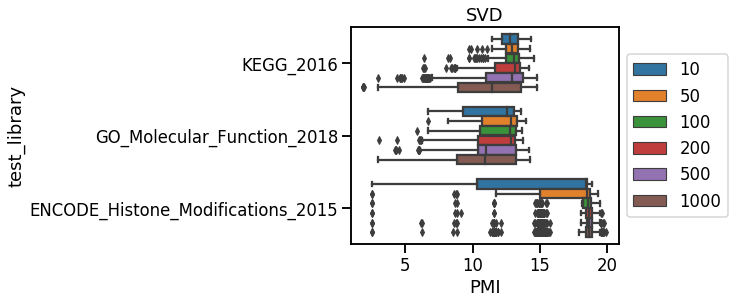

In [13]:
fig, ax = plt.subplots()
ax = sns.boxplot(x='PMI', y='test_library', data=pmi_scores_all,
            hue='n_topics',
                  ax=ax
            )
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));
ax.set_title('SVD');

In [16]:
pmi_scores_dummies = []
for n_topics in n_topics_all:
    pmi_scores_dummy = evaluations.topics_coherence_pmis_wrapper(X_topics_svd, libs_y, tf_mat.T,
                                                              terms_df['library'],
                                                               dummy=True,
                                                               topn=10,
                                                               model_name='Random'
                                                              )
    pmi_scores_dummy['n_topics'] = n_topics
    pmi_scores_dummies.append(pmi_scores_dummy)

KEGG_2016 (293, 32309)
GO_Molecular_Function_2018 (1151, 32309)
ENCODE_Histone_Modifications_2015 (412, 32309)
KEGG_2016 (293, 32309)
GO_Molecular_Function_2018 (1151, 32309)
ENCODE_Histone_Modifications_2015 (412, 32309)
KEGG_2016 (293, 32309)
GO_Molecular_Function_2018 (1151, 32309)
ENCODE_Histone_Modifications_2015 (412, 32309)
KEGG_2016 (293, 32309)
GO_Molecular_Function_2018 (1151, 32309)
ENCODE_Histone_Modifications_2015 (412, 32309)
KEGG_2016 (293, 32309)
GO_Molecular_Function_2018 (1151, 32309)
ENCODE_Histone_Modifications_2015 (412, 32309)
KEGG_2016 (293, 32309)
GO_Molecular_Function_2018 (1151, 32309)
ENCODE_Histone_Modifications_2015 (412, 32309)


In [17]:
pmi_scores_dummies = pd.concat(pmi_scores_dummies)

In [18]:
pmi_scores_all_with_controls = pd.concat([pmi_scores_all, pmi_scores_dummies])

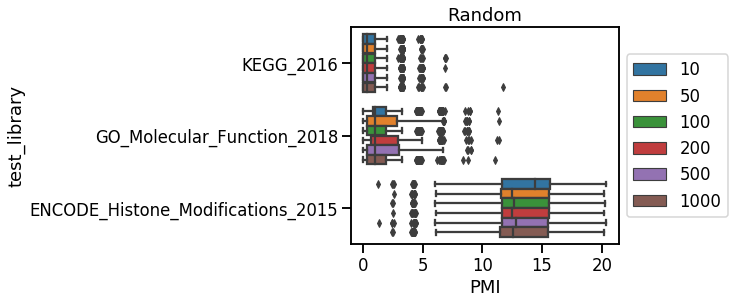

In [19]:
fig, ax = plt.subplots()
ax = sns.boxplot(x='PMI', y='test_library', data=pmi_scores_dummies,
            hue='n_topics',
                  ax=ax
            )
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));
ax.set_title('Random');

/Users/maayanlab/Documents/Zichen_Projects/venv3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


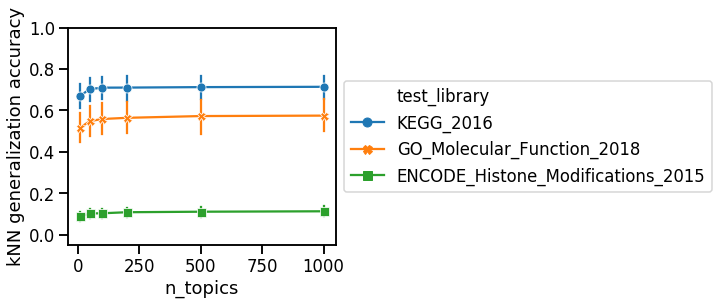

In [19]:
ax = sns.lineplot(x='n_topics', y='accuracy', data=knn_scores_all,
            hue='test_library',
             err_style="bars",
                  style='test_library',
                  markers=True,
                  dashes=False, 
            )

ax.set_ylabel('kNN generalization accuracy')
ax.set_ylim([-0.05, 1]);
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));
ax.set_title('SVD')

In [21]:
knn_scores_tfidf = evaluations.NN_generalization_accuracy_wrapper(tfidf_mat_x.T, libs_y, tf_mat.T, 
                                                                terms_df['library'],
                                               dummy=False, 
                                               model_name='TF-IDF')

KEGG_2016 (32309, 293)
GO_Molecular_Function_2018 (32309, 1151)
ENCODE_Histone_Modifications_2015 (32309, 412)


In [22]:
knn_scores_tfidf['n_topics'] = tfidf_mat_x.shape[1]

In [23]:
knn_scores_baseline = evaluations.NN_generalization_accuracy_wrapper(tfidf_mat_x.T, libs_y, tf_mat.T, 
                                                                terms_df['library'],
                                               dummy=True, 
                                               model_name='baseline')

KEGG_2016 (32309, 293)
GO_Molecular_Function_2018 (32309, 1151)
ENCODE_Histone_Modifications_2015 (32309, 412)


In [24]:
knn_scores_baseline['n_topics'] = 0

In [25]:
knn_scores_with_controls = pd.concat([knn_scores_all, knn_scores_tfidf, knn_scores_baseline])
knn_scores_with_controls.shape

(120, 4)

In [57]:
sns.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

/Users/maayanlab/Documents/Zichen_Projects/venv3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


KEGG_2016 0.35689733956437236 0.0214547846935423
KEGG_2016 0.7320564436065242 0.06889657538112995
GO_Molecular_Function_2018 0.16995269716051228 0.009269088694309337
GO_Molecular_Function_2018 0.5796201967177682 0.09955322496680921
ENCODE_Histone_Modifications_2015 0.0 0.0
ENCODE_Histone_Modifications_2015 0.10814217016500353 0.03329840428005412


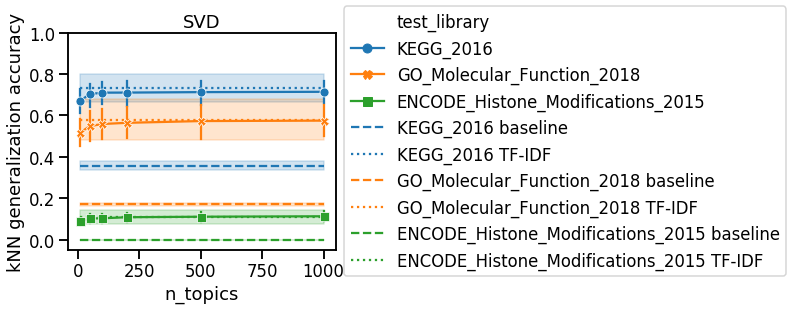

In [77]:
fig, ax = plt.subplots()
ax = sns.lineplot(x='n_topics', y='accuracy', data=knn_scores_all,
            hue='test_library',
             err_style="bars",
                  style='test_library',
                  markers=True,
                  dashes=False, 
                  ax=ax
            )

grouped_baseline = knn_scores_baseline.groupby('test_library')
grouped_tfidf = knn_scores_tfidf.groupby('test_library')
colors = sns.color_palette()

for i, lib in enumerate(libs_y):
    sub_df = grouped_baseline.get_group(lib)
    mean = sub_df['accuracy'].mean()
    std = sub_df['accuracy'].std()
    print(lib, mean, std)
    ax.hlines(mean, 
              n_topics_all[0], n_topics_all[-1],
               color=colors[i],
              linestyles='dashed',
               label='%s baseline' % lib)
    ax.fill_between(n_topics_all, mean+std, mean-std, alpha=0.2,
                   color=colors[i])
    
    sub_df = grouped_tfidf.get_group(lib)
    mean = sub_df['accuracy'].mean()
    std = sub_df['accuracy'].std()
    print(lib, mean, std)
    ax.hlines(mean, 
              n_topics_all[0], n_topics_all[-1],
               color=colors[i],
              linestyles='dotted',
               label='%s TF-IDF' % lib)
    ax.fill_between(n_topics_all, mean+std, mean-std, alpha=0.2,
                   color=colors[i])


ax.set_ylabel('kNN generalization accuracy')
ax.set_ylim([-0.05, 1]);
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));
ax.set_title('SVD');

/Users/maayanlab/Documents/Zichen_Projects/venv3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


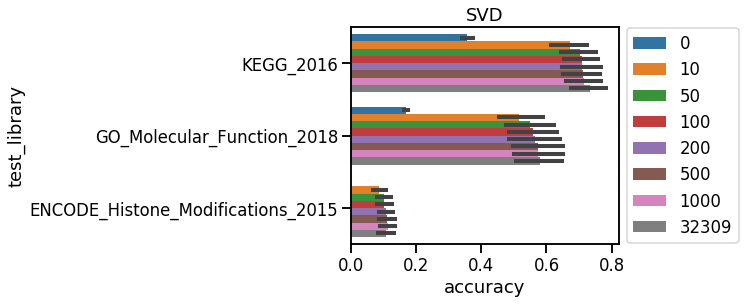

In [83]:
fig, ax = plt.subplots()
ax = sns.barplot(x='accuracy', y='test_library', data=knn_scores_with_controls,
            hue='n_topics',
                  ax=ax
            )
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5));
ax.set_title('SVD');

In [84]:
knn_scores_all = []
for n_topics in n_topics_all:
    lda = decomposition.LatentDirichletAllocation(n_components=n_topics, 
                                                  n_jobs=10,
                                     random_state=2018)
    lda.fit(tf_mat_x)

    X_topics_lda = lda.components_.T # genes by topics matrix
    print(X_topics_lda.shape)
    
    knn_scores_lda = evaluations.NN_generalization_accuracy_wrapper(X_topics_lda, libs_y, tf_mat.T, 
                                                                    terms_df['library'],
                                                   dummy=False, 
                                                   model_name='LDA')
    knn_scores_lda['n_topics'] = n_topics
    knn_scores_all.append(knn_scores_lda)

(32309, 10)
KEGG_2016 (32309, 293)
GO_Molecular_Function_2018 (32309, 1151)
ENCODE_Histone_Modifications_2015 (32309, 412)
(32309, 50)
KEGG_2016 (32309, 293)
GO_Molecular_Function_2018 (32309, 1151)
ENCODE_Histone_Modifications_2015 (32309, 412)
(32309, 100)
KEGG_2016 (32309, 293)
GO_Molecular_Function_2018 (32309, 1151)
ENCODE_Histone_Modifications_2015 (32309, 412)
(32309, 200)
KEGG_2016 (32309, 293)
GO_Molecular_Function_2018 (32309, 1151)
ENCODE_Histone_Modifications_2015 (32309, 412)
(32309, 500)
KEGG_2016 (32309, 293)
GO_Molecular_Function_2018 (32309, 1151)
ENCODE_Histone_Modifications_2015 (32309, 412)
(32309, 1000)
KEGG_2016 (32309, 293)
GO_Molecular_Function_2018 (32309, 1151)
ENCODE_Histone_Modifications_2015 (32309, 412)
